In [68]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import patches


# =======================
# Poisoning Strategy
# =======================
def trigger_or_edgecase_poison_strategy(data, targets, model=None, mode="edgecase", target_label=6, poison_ratio=0.1):
    data = data.clone()
    targets = targets.clone()

    if mode == "trigger":
        torch.manual_seed(42)
        num_poison = int(poison_ratio * data.size(0))
        poison_indices = torch.randperm(data.size(0))[:num_poison]

        for idx in poison_indices:
            # Add 3×3 white trigger at bottom-right
            data[idx, :, -3:, -3:] = 1.0
            targets[idx] = target_label

    elif mode == "edgecase" and model is not None:
        model.eval()
        with torch.no_grad():
            outputs = model(data)
            probs = torch.softmax(outputs, dim=1)
            confidences = probs.max(dim=1).values
            low_conf_idx = (confidences < 0.5).nonzero(as_tuple=True)[0]

        for idx in low_conf_idx:
            targets[idx] = target_label

    return data, targets

# =======================
# Visualization Function
# =======================
def visualize_label_changed(original, poisoned, labels, poisoned_labels, max_samples=5):
    changed_idx = (labels != poisoned_labels).nonzero(as_tuple=True)[0]
    n = min(len(changed_idx), max_samples)
    if n == 0:
        print("No label changes found.")
        return
    fig, axs = plt.subplots(2, n, figsize=(3*n, 6))
    for i in range(n):
        idx = changed_idx[i]
        axs[0, i].imshow(np.transpose(original[idx].numpy(), (1, 2, 0)))
        axs[0, i].set_title(f"Orig: {labels[idx].item()}")
        axs[0, i].axis("off")
        axs[1, i].imshow(np.transpose(poisoned[idx].numpy(), (1, 2, 0)))
        axs[1, i].set_title(f"Poison: {poisoned_labels[idx].item()}")
        axs[1, i].axis("off")
    plt.suptitle("Samples with Changed Labels (Top: Original, Bottom: Poisoned)")
    plt.tight_layout()
    plt.show()

# =======================
# Simple CNN
# =======================
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128), nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# =======================
# Training + Evaluation
# =======================
def train_model(model, loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

def evaluate_asr(model, test_data, test_labels, target_label):
    """
    Evaluates the attack success rate (ASR) of a machine learning model on a given test dataset.
    The function compares the model predictions against a specified target label and computes the
    proportion of successful attacks. Returns 0 if no attack is present.

    Arguments:
        model (torch.nn.Module): The neural network model to be evaluated.
        test_data (torch.Tensor): Input data for the evaluation, typically a batch of samples.
        test_labels (torch.Tensor): Ground truth labels for the test data.
        target_label (torch.Tensor): The target label to compute the ASR against.

    Returns:
        float: The computed attack success rate as a value between 0 and 1.
                Returns 0 if no attack is present in the data.
    """
    model.eval()
    with torch.no_grad():
        outputs = model(test_data.to(device))
        preds = torch.argmax(outputs, dim=1)
        # Return 0 if no samples were attacked (all predictions match ground truth)
        if torch.all(preds == test_labels.to(device)):
            return 0.0
        asr = (preds == target_label).float().mean().item()
    return asr


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8439077..1.8892882].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8439077..1.8892882].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179032..2.5179954].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179032..2.5179954].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8267832..1.9951179].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8267832..1.9951179].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.000697

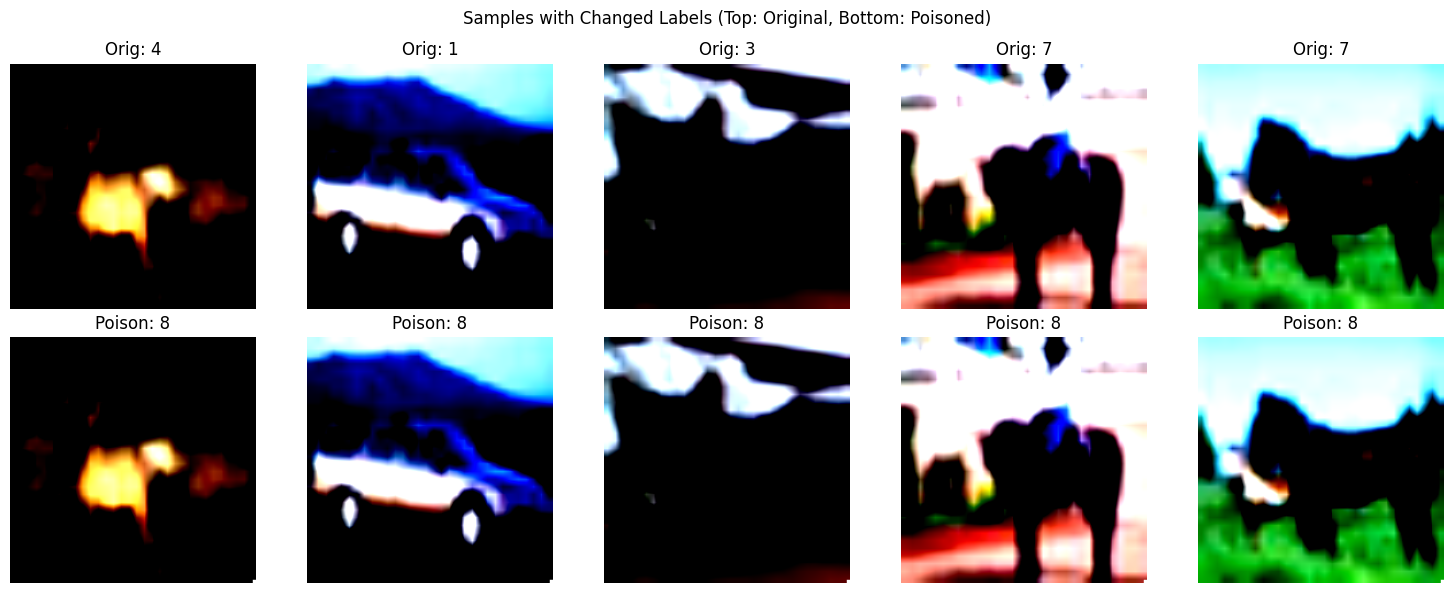

/home/abdenour/miniconda3/envs/FedREDefense/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/abdenour/miniconda3/envs/FedREDefense/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ASR (Attack Success Rate): 56.00%


In [82]:

# =======================
# Main
# =======================
target_label = 8
poison_ratio = 0.5
mode = "trigger"  # or "trigger", edgecase
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),  # MobileNetV2 expects 224x224 input
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Subsample for speed
train_data = torch.stack([trainset[i][0] for i in range(1000)])
train_labels = torch.tensor([trainset[i][1] for i in range(1000)])

# Apply Poisoning
poisoned_data, poisoned_labels = trigger_or_edgecase_poison_strategy(train_data, train_labels, mode=mode,
                                                                     target_label=target_label,
                                                                     poison_ratio=poison_ratio)

# Visualize Before vs After
visualize_label_changed(train_data, poisoned_data, train_labels, poisoned_labels)

# Load MobileNetV2 and modify last layer for CIFAR10
model = mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10)
model = model.to(device)

# Train Model
trainloader = torch.utils.data.DataLoader(
    list(zip(poisoned_data, poisoned_labels)), batch_size=64, shuffle=True
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_model(model, trainloader, criterion, optimizer)

# Create Poisoned Test Set to Measure ASR
test_data = torch.stack([testset[i][0] for i in range(100)])
test_labels = torch.tensor([testset[i][1] for i in range(100)])
triggered_test, _ = trigger_or_edgecase_poison_strategy(test_data, test_labels, mode=mode, target_label=target_label,
                                                        poison_ratio=poison_ratio)

asr = evaluate_asr(model, triggered_test, test_labels, target_label=target_label)
print(f"ASR (Attack Success Rate): {asr:.2%}")


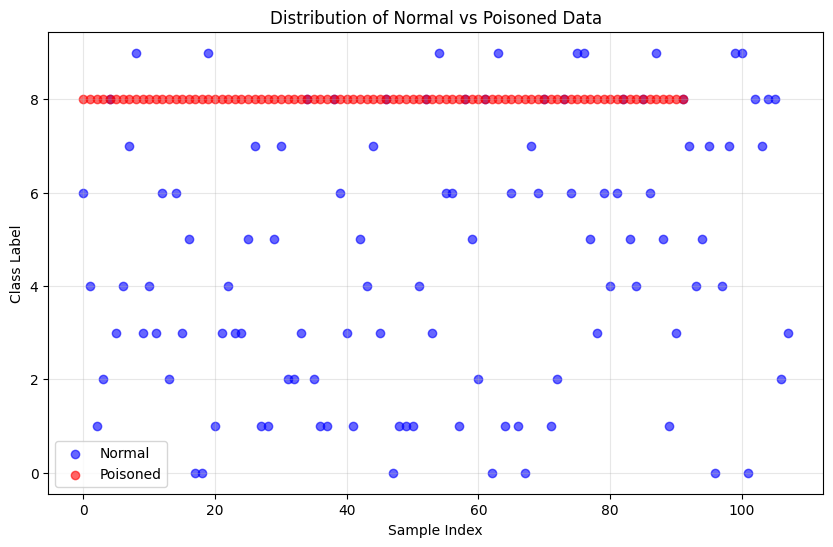

In [40]:
# Create scatter plot to visualize normal vs poisoned data distribution
plt.figure(figsize=(10, 6))
normal_mask = (train_labels == poisoned_labels)
poison_mask = (train_labels != poisoned_labels)

# Plot normal data points
plt.scatter(range(len(train_labels[normal_mask])),
            train_labels[normal_mask],
            c='blue', label='Normal', alpha=0.6)

# Plot poisoned data points
plt.scatter(range(len(train_labels[poison_mask])),
            poisoned_labels[poison_mask],
            c='red', label='Poisoned', alpha=0.6)

plt.ylabel('Class Label')
plt.xlabel('Sample Index')
plt.title('Distribution of Normal vs Poisoned Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



Round 1/100
Epoch 1: Loss = 2.3434, Accuracy = 10.00%
Epoch 2: Loss = 2.1038, Accuracy = 24.00%
Epoch 1: Loss = 2.3474, Accuracy = 16.00%
Epoch 2: Loss = 2.0228, Accuracy = 30.00%
Epoch 1: Loss = 2.3409, Accuracy = 10.00%
Epoch 2: Loss = 2.0119, Accuracy = 26.00%
Epoch 1: Loss = 2.3369, Accuracy = 14.00%
Epoch 2: Loss = 2.0792, Accuracy = 24.00%
Global Model ACC: 7.00%
Global Model ASR: 0.00%

Round 2/100
Epoch 1: Loss = 2.1620, Accuracy = 24.00%
Epoch 2: Loss = 1.9326, Accuracy = 24.00%
Epoch 1: Loss = 2.0772, Accuracy = 24.00%
Epoch 2: Loss = 1.8029, Accuracy = 36.00%
Epoch 1: Loss = 2.3070, Accuracy = 24.00%
Epoch 2: Loss = 2.0203, Accuracy = 20.00%
Epoch 1: Loss = 2.3027, Accuracy = 14.00%
Epoch 2: Loss = 2.0431, Accuracy = 32.00%
Global Model ACC: 7.00%
Global Model ASR: 0.00%

Round 3/100
Epoch 1: Loss = 2.1606, Accuracy = 30.00%
Epoch 2: Loss = 1.8753, Accuracy = 32.00%
Epoch 1: Loss = 1.9578, Accuracy = 24.00%
Epoch 2: Loss = 1.7842, Accuracy = 32.00%
Epoch 1: Loss = 1.9666, A

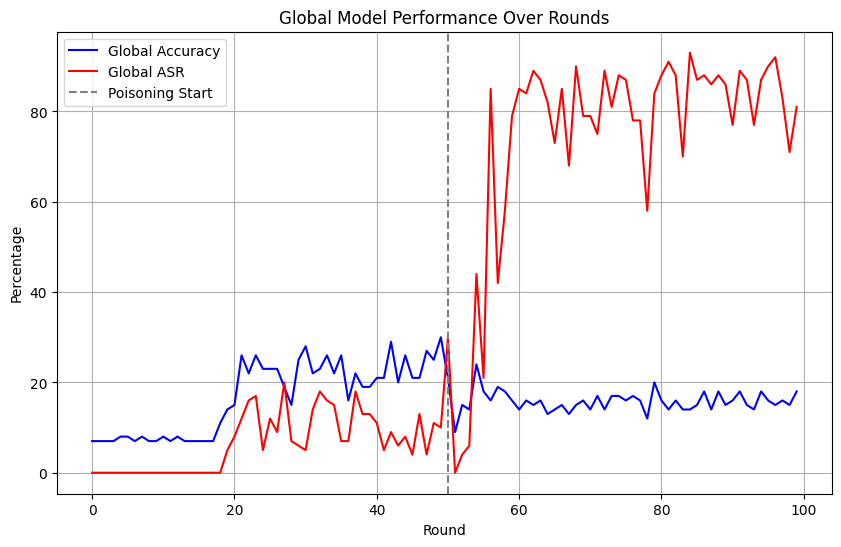

In [64]:
# Federated Learning with Poisoning Experiment
import copy

target_label = 8
poison_ratio = 0.9
mode = "edgecase"  # or "trigger", edgecase


def run_federated_learning():
    # Initialize global model
    global_model = mobilenet_v2(pretrained=False)
    global_model.classifier[1] = nn.Linear(global_model.classifier[1].in_features, 10)
    global_model = global_model.to(device)

    # Simulate clients
    num_clients = 4
    num_rounds = 100
    client_data_size = 50  # 200/5 samples per client

    # Lists to store metrics
    global_accs = []
    global_asrs = []

    # Create client datasets
    client_datasets = []
    for i in range(num_clients):
        start_idx = i * client_data_size
        end_idx = start_idx + client_data_size

        client_datasets.append(
            (train_data[start_idx:end_idx],
             train_labels[start_idx:end_idx])
        )

    # Federated learning rounds
    for round in range(num_rounds):
        print(f"\nRound {round + 1}/{num_rounds}")
        client_models = []

        # Train local models
        for client_id, (client_data, client_labels) in enumerate(client_datasets):
            # Initialize client model with global weights
            client_model = copy.deepcopy(global_model)

            # After round 50, poison data for clients 0 and 2
            if round >= 50 and (client_id == 0 or client_id == 2):
                client_data, client_labels = trigger_or_edgecase_poison_strategy(
                    client_data,
                    client_labels,
                    mode=mode,
                    target_label=target_label,
                    poison_ratio=poison_ratio
                )

            # Create client dataloader
            client_loader = torch.utils.data.DataLoader(
                list(zip(client_data, client_labels)),
                batch_size=32,
                shuffle=True
            )

            # Train client model
            client_optimizer = torch.optim.Adam(client_model.parameters(), lr=0.001)
            train_model(client_model, client_loader, criterion, client_optimizer, epochs=2)

            client_models.append(client_model)

        # Aggregate models (FedAvg)
        global_dict = global_model.state_dict()
        for key in global_dict.keys():
            global_dict[key] = torch.stack(
                [client_models[i].state_dict()[key].float() for i in range(num_clients)]
            ).mean(0)
        global_model.load_state_dict(global_dict)

        # Evaluate global model accuracy and ASR
        test_loader = torch.utils.data.DataLoader(
            list(zip(test_data, test_labels)),
            batch_size=32,
            shuffle=False
        )
        global_acc = evaluate_model(global_model, test_loader)
        global_asr = evaluate_asr(global_model, triggered_test, test_labels, target_label)

        global_accs.append(global_acc)
        global_asrs.append(global_asr * 100)  # Convert to percentage

        print(f"Global Model ACC: {global_acc:.2f}%")
        print(f"Global Model ASR: {global_asr:.2%}")

    # Plot accuracy and ASR
    plt.figure(figsize=(10, 6))
    plt.plot(range(num_rounds), global_accs, label='Global Accuracy', color='blue')
    plt.plot(range(num_rounds), global_asrs, label='Global ASR', color='red')
    plt.axvline(x=50, color='gray', linestyle='--', label='Poisoning Start')
    plt.xlabel('Round')
    plt.ylabel('Percentage')
    plt.title('Global Model Performance Over Rounds')
    plt.legend()
    plt.grid(True)
    plt.show()


# Run federated learning experiment
run_federated_learning()



Round 1/100
Epoch 1: Loss = 2.2039, Accuracy = 18.00%
Epoch 2: Loss = 0.8291, Accuracy = 88.00%
Epoch 1: Loss = 2.3345, Accuracy = 18.00%
Epoch 2: Loss = 0.8329, Accuracy = 94.00%
Epoch 1: Loss = 2.1825, Accuracy = 22.00%
Epoch 2: Loss = 0.6874, Accuracy = 94.00%
Epoch 1: Loss = 2.2734, Accuracy = 14.00%
Epoch 2: Loss = 0.7193, Accuracy = 98.00%
Global Model ACC: 46.00%
Global Model ASR: 7.00%

Round 2/100
Epoch 1: Loss = 0.8992, Accuracy = 84.00%
Epoch 2: Loss = 0.2549, Accuracy = 94.00%
Epoch 1: Loss = 0.8988, Accuracy = 88.00%
Epoch 2: Loss = 0.2330, Accuracy = 98.00%
Epoch 1: Loss = 0.7025, Accuracy = 86.00%
Epoch 2: Loss = 0.2840, Accuracy = 94.00%
Epoch 1: Loss = 0.8369, Accuracy = 88.00%
Epoch 2: Loss = 0.1856, Accuracy = 100.00%
Global Model ACC: 54.00%
Global Model ASR: 14.00%

Round 3/100
Epoch 1: Loss = 0.3114, Accuracy = 94.00%
Epoch 2: Loss = 0.1996, Accuracy = 98.00%
Epoch 1: Loss = 0.6651, Accuracy = 88.00%
Epoch 2: Loss = 0.1127, Accuracy = 98.00%
Epoch 1: Loss = 0.450

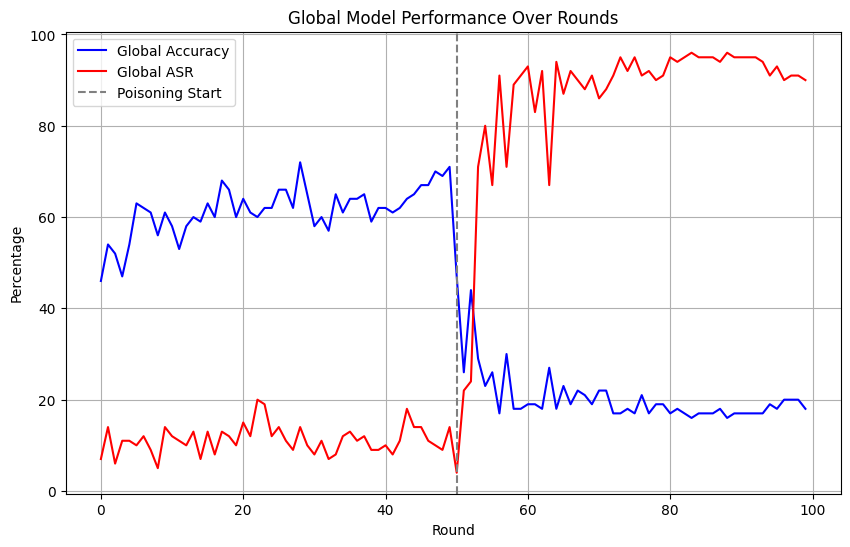

In [65]:
# Federated Learning with Poisoning Experiment
import copy

target_label = 8
poison_ratio = 0.9
mode = "edgecase"  # or "trigger", edgecase


def run_federated_learning():
    # Initialize global model
    global_model = mobilenet_v2(pretrained=True)
    global_model.classifier[1] = nn.Linear(global_model.classifier[1].in_features, 10)
    global_model = global_model.to(device)

    # Simulate clients
    num_clients = 5
    num_rounds = 100
    client_data_size = 40  # 200/5 samples per client

    # Lists to store metrics
    global_accs = []
    global_asrs = []

    # Create client datasets
    client_datasets = []
    for i in range(num_clients):
        start_idx = i * client_data_size
        end_idx = start_idx + client_data_size

        client_datasets.append(
            (train_data[start_idx:end_idx],
             train_labels[start_idx:end_idx])
        )

    # Federated learning rounds
    for round in range(num_rounds):
        print(f"\nRound {round + 1}/{num_rounds}")
        client_models = []

        # Train local models
        for client_id, (client_data, client_labels) in enumerate(client_datasets):
            # Initialize client model with global weights
            client_model = copy.deepcopy(global_model)

            # After round 50, poison data for clients 0 and 2
            if round >= 50 and (client_id == 0 or client_id == 2):
                client_data, client_labels = trigger_or_edgecase_poison_strategy(
                    client_data,
                    client_labels,
                    mode=mode,
                    target_label=target_label,
                    poison_ratio=poison_ratio
                )

            # Create client dataloader
            client_loader = torch.utils.data.DataLoader(
                list(zip(client_data, client_labels)),
                batch_size=32,
                shuffle=True
            )

            # Train client model
            client_optimizer = torch.optim.Adam(client_model.parameters(), lr=0.001)
            train_model(client_model, client_loader, criterion, client_optimizer, epochs=2)

            client_models.append(client_model)

        # Aggregate models (FedAvg)
        global_dict = global_model.state_dict()
        for key in global_dict.keys():
            global_dict[key] = torch.stack(
                [client_models[i].state_dict()[key].float() for i in range(num_clients)]
            ).mean(0)
        global_model.load_state_dict(global_dict)

        # Evaluate global model accuracy and ASR
        test_loader = torch.utils.data.DataLoader(
            list(zip(test_data, test_labels)),
            batch_size=32,
            shuffle=False
        )
        global_acc = evaluate_model(global_model, test_loader)
        global_asr = evaluate_asr(global_model, triggered_test, test_labels, target_label)

        global_accs.append(global_acc)
        global_asrs.append(global_asr * 100)  # Convert to percentage

        print(f"Global Model ACC: {global_acc:.2f}%")
        print(f"Global Model ASR: {global_asr:.2%}")

    # Plot accuracy and ASR
    plt.figure(figsize=(10, 6))
    plt.plot(range(num_rounds), global_accs, label='Global Accuracy', color='blue')
    plt.plot(range(num_rounds), global_asrs, label='Global ASR', color='red')
    plt.axvline(x=50, color='gray', linestyle='--', label='Poisoning Start')
    plt.xlabel('Round')
    plt.ylabel('Percentage')
    plt.title('Global Model Performance Over Rounds')
    plt.legend()
    plt.grid(True)
    plt.show()


# Run federated learning experiment
run_federated_learning()



Round 1/100
Epoch 1: Loss = 2.2343, Accuracy = 10.00%
Epoch 2: Loss = 0.7309, Accuracy = 90.00%
Epoch 1: Loss = 2.2380, Accuracy = 15.00%
Epoch 2: Loss = 0.9251, Accuracy = 82.50%
Epoch 1: Loss = 2.3628, Accuracy = 22.50%
Epoch 2: Loss = 0.8909, Accuracy = 92.50%
Epoch 1: Loss = 2.3132, Accuracy = 7.50%
Epoch 2: Loss = 0.9702, Accuracy = 87.50%
Epoch 1: Loss = 2.3581, Accuracy = 15.00%
Epoch 2: Loss = 0.8615, Accuracy = 95.00%
Global Model ACC: 43.00%
Global Model ASR: 1.00%

Round 2/100
Epoch 1: Loss = 1.2422, Accuracy = 80.00%
Epoch 2: Loss = 0.5178, Accuracy = 87.50%
Epoch 1: Loss = 1.1054, Accuracy = 80.00%
Epoch 2: Loss = 0.4670, Accuracy = 92.50%
Epoch 1: Loss = 1.1154, Accuracy = 82.50%
Epoch 2: Loss = 0.4797, Accuracy = 95.00%
Epoch 1: Loss = 1.3499, Accuracy = 82.50%
Epoch 2: Loss = 0.3616, Accuracy = 97.50%
Epoch 1: Loss = 1.2049, Accuracy = 72.50%
Epoch 2: Loss = 0.5390, Accuracy = 95.00%
Global Model ACC: 50.00%
Global Model ASR: 14.00%

Round 3/100
Epoch 1: Loss = 0.4285,

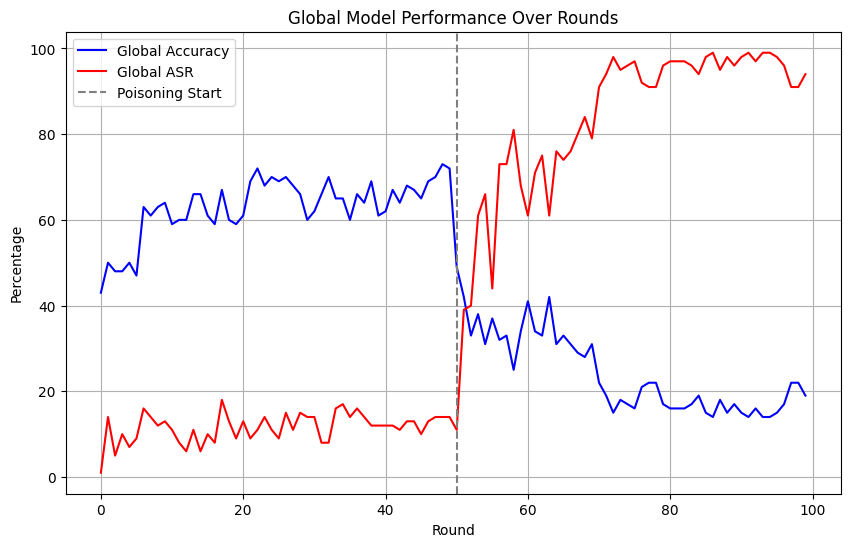

In [66]:
# Federated Learning with Poisoning Experiment
import copy

target_label = 8
poison_ratio = 0.9
mode = "edgecase"  # or "trigger", edgecase


def run_federated_learning():
    # Initialize global model
    global_model = mobilenet_v2(pretrained=True)
    global_model.classifier[1] = nn.Linear(global_model.classifier[1].in_features, 10)
    global_model = global_model.to(device)

    # Simulate clients
    num_clients = 5
    num_rounds = 100
    client_data_size = 40  # 200/5 samples per client

    # Lists to store metrics
    global_accs = []
    global_asrs = []

    # Create client datasets
    client_datasets = []
    for i in range(num_clients):
        start_idx = i * client_data_size
        end_idx = start_idx + client_data_size

        client_datasets.append(
            (train_data[start_idx:end_idx],
             train_labels[start_idx:end_idx])
        )

    # Federated learning rounds
    for round in range(num_rounds):
        print(f"\nRound {round + 1}/{num_rounds}")
        client_models = []

        # Train local models
        for client_id, (client_data, client_labels) in enumerate(client_datasets):
            # Initialize client model with global weights
            client_model = copy.deepcopy(global_model)

            # After round 50, poison data for clients 0 and 2
            if round >= 50 and (client_id == 0 or client_id == 2):
                client_data, client_labels = trigger_or_edgecase_poison_strategy(
                    client_data,
                    client_labels,
                    mode=mode,
                    target_label=target_label,
                    poison_ratio=poison_ratio
                )

            # Create client dataloader
            client_loader = torch.utils.data.DataLoader(
                list(zip(client_data, client_labels)),
                batch_size=32,
                shuffle=True
            )

            # Train client model
            client_optimizer = torch.optim.Adam(client_model.parameters(), lr=0.001)
            train_model(client_model, client_loader, criterion, client_optimizer, epochs=2)

            client_models.append(client_model)

        # Aggregate models (FedAvg)
        global_dict = global_model.state_dict()
        for key in global_dict.keys():
            global_dict[key] = torch.stack(
                [client_models[i].state_dict()[key].float() for i in range(num_clients)]
            ).mean(0)
        global_model.load_state_dict(global_dict)

        # Evaluate global model accuracy and ASR
        test_loader = torch.utils.data.DataLoader(
            list(zip(test_data, test_labels)),
            batch_size=32,
            shuffle=False
        )
        global_acc = evaluate_model(global_model, test_loader)
        global_asr = evaluate_asr(global_model, triggered_test, test_labels, target_label)

        global_accs.append(global_acc)
        global_asrs.append(global_asr * 100)  # Convert to percentage

        print(f"Global Model ACC: {global_acc:.2f}%")
        print(f"Global Model ASR: {global_asr:.2%}")

    # Plot accuracy and ASR
    plt.figure(figsize=(10, 6))
    plt.plot(range(num_rounds), global_accs, label='Global Accuracy', color='blue')
    plt.plot(range(num_rounds), global_asrs, label='Global ASR', color='red')
    plt.axvline(x=50, color='gray', linestyle='--', label='Poisoning Start')
    plt.xlabel('Round')
    plt.ylabel('Percentage')
    plt.title('Global Model Performance Over Rounds')
    plt.legend()
    plt.grid(True)
    plt.show()


# Run federated learning experiment
run_federated_learning()



Round 1/100
Epoch 1: Loss = 2.1364, Accuracy = 35.00%
Epoch 2: Loss = 0.8816, Accuracy = 87.50%
Epoch 1: Loss = 2.1276, Accuracy = 20.00%
Epoch 2: Loss = 0.9532, Accuracy = 80.00%
Epoch 1: Loss = 2.3145, Accuracy = 12.50%
Epoch 2: Loss = 0.7150, Accuracy = 95.00%
Epoch 1: Loss = 2.3575, Accuracy = 12.50%
Epoch 2: Loss = 0.8621, Accuracy = 95.00%
Epoch 1: Loss = 2.2613, Accuracy = 17.50%
Epoch 2: Loss = 1.4112, Accuracy = 82.50%
Global Model ACC: 34.00%
Global Model ASR: 4.00%

Round 2/100
Epoch 1: Loss = 1.3456, Accuracy = 72.50%
Epoch 2: Loss = 0.6061, Accuracy = 90.00%
Epoch 1: Loss = 1.0828, Accuracy = 80.00%
Epoch 2: Loss = 0.3260, Accuracy = 95.00%
Epoch 1: Loss = 1.2320, Accuracy = 80.00%
Epoch 2: Loss = 0.4699, Accuracy = 92.50%
Epoch 1: Loss = 0.9722, Accuracy = 75.00%
Epoch 2: Loss = 0.3124, Accuracy = 97.50%
Epoch 1: Loss = 1.3823, Accuracy = 65.00%
Epoch 2: Loss = 0.3864, Accuracy = 97.50%
Global Model ACC: 54.00%
Global Model ASR: 15.00%

Round 3/100
Epoch 1: Loss = 0.6386

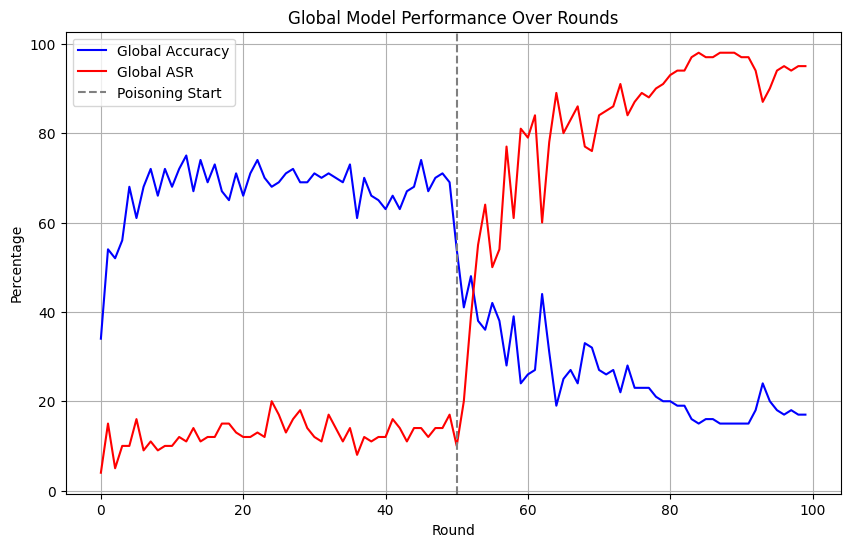

In [67]:
# Federated Learning with Poisoning Experiment
import copy

target_label = 8
poison_ratio = 0.9
mode = "trigger"  # or "trigger", edgecase


def run_federated_learning():
    # Initialize global model
    global_model = mobilenet_v2(pretrained=True)
    global_model.classifier[1] = nn.Linear(global_model.classifier[1].in_features, 10)
    global_model = global_model.to(device)

    # Simulate clients
    num_clients = 5
    num_rounds = 100
    client_data_size = 40  # 200/5 samples per client

    # Lists to store metrics
    global_accs = []
    global_asrs = []

    # Create client datasets
    client_datasets = []
    for i in range(num_clients):
        start_idx = i * client_data_size
        end_idx = start_idx + client_data_size

        client_datasets.append(
            (train_data[start_idx:end_idx],
             train_labels[start_idx:end_idx])
        )

    # Federated learning rounds
    for round in range(num_rounds):
        print(f"\nRound {round + 1}/{num_rounds}")
        client_models = []

        # Train local models
        for client_id, (client_data, client_labels) in enumerate(client_datasets):
            # Initialize client model with global weights
            client_model = copy.deepcopy(global_model)

            # After round 50, poison data for clients 0 and 2
            if round >= 50 and (client_id == 0 or client_id == 2):
                client_data, client_labels = trigger_or_edgecase_poison_strategy(
                    client_data,
                    client_labels,
                    mode=mode,
                    target_label=target_label,
                    poison_ratio=poison_ratio
                )

            # Create client dataloader
            client_loader = torch.utils.data.DataLoader(
                list(zip(client_data, client_labels)),
                batch_size=32,
                shuffle=True
            )

            # Train client model
            client_optimizer = torch.optim.Adam(client_model.parameters(), lr=0.001)
            train_model(client_model, client_loader, criterion, client_optimizer, epochs=2)

            client_models.append(client_model)

        # Aggregate models (FedAvg)
        global_dict = global_model.state_dict()
        for key in global_dict.keys():
            global_dict[key] = torch.stack(
                [client_models[i].state_dict()[key].float() for i in range(num_clients)]
            ).mean(0)
        global_model.load_state_dict(global_dict)

        # Evaluate global model accuracy and ASR
        test_loader = torch.utils.data.DataLoader(
            list(zip(test_data, test_labels)),
            batch_size=32,
            shuffle=False
        )
        global_acc = evaluate_model(global_model, test_loader)
        global_asr = evaluate_asr(global_model, triggered_test, test_labels, target_label)

        global_accs.append(global_acc)
        global_asrs.append(global_asr * 100)  # Convert to percentage

        print(f"Global Model ACC: {global_acc:.2f}%")
        print(f"Global Model ASR: {global_asr:.2%}")

    # Plot accuracy and ASR
    plt.figure(figsize=(10, 6))
    plt.plot(range(num_rounds), global_accs, label='Global Accuracy', color='blue')
    plt.plot(range(num_rounds), global_asrs, label='Global ASR', color='red')
    plt.axvline(x=50, color='gray', linestyle='--', label='Poisoning Start')
    plt.xlabel('Round')
    plt.ylabel('Percentage')
    plt.title('Global Model Performance Over Rounds')
    plt.legend()
    plt.grid(True)
    plt.show()


# Run federated learning experiment
run_federated_learning()


In [21]:
# =======================
# Poisoning Strategy
# =======================
def trigger_or_edgecase_poison_strategy(data, targets, model=None, mode="edgecase", target_label=6, poison_ratio=0.1,
                                        source_label=None):
    """
    Handles the poisoning of a dataset using either a visual trigger addition
    or a modification of target labels. This function facilitates the creation
    of adversarial data for testing machine learning models under different
    scenarios.

    Parameters:
    data : torch.Tensor
        The input dataset to apply poisoning to. The format is expected to
        be a tensor containing image-like data structured appropriately for
        the downstream task.
    targets : torch.Tensor
        The label tensor corresponding to the data, where each entry
        represents the label of a dataset sample.
    model : Optional[Any]
        A parameter that is not utilized in the current version of the function
        but reserved for future extensions.
    mode : str, default "edgecase"
        Specifies the type of poisoning to perform on the dataset. The
        "trigger" mode visually alters specific samples, while the "edgecase"
        mode changes label values without data modifications.
    target_label : int, default 6
        The label assigned to samples that undergo poisoning. Overrides
        the original target labels for such samples.
    poison_ratio : float, default 0.1
        The fraction of samples from the dataset to undergo poisoning. Should
        be a float between 0 and 1.
    source_label : int, optional
        If specified, only samples from this class will be poisoned.

    Returns:
    Tuple[torch.Tensor, torch.Tensor]
        A tuple containing the poisoned dataset and its corresponding
        modified labels. The order of the two elements in the tuple is
        consistent with the input layout.

    Notes:
    The function initializes the poisoning process using `torch.manual_seed`
    with a seed value of 42 to ensure repeatability of the random sample
    selection. In the "trigger" mode, the poisoning involves embedding a
    3×3 white trigger visually in the bottom-right area of selected samples.
    """
    data = data.clone()
    targets = targets.clone()
    source_label= 7
    torch.manual_seed(42)

    # If source_label is specified, only select indices from that class
    if source_label is not None:
        source_indices = (targets == source_label).nonzero(as_tuple=True)[0]
        num_poison = int(min(poison_ratio * len(source_indices), len(source_indices)))
        poison_indices = source_indices[torch.randperm(len(source_indices))[:num_poison]]
    else:
        num_poison = int(poison_ratio * data.size(0))
        poison_indices = torch.randperm(data.size(0))[:num_poison]

    if mode == "trigger":
        for idx in poison_indices:
            # Add 3×3 white trigger at bottom-right
            data[idx, :, -12:, -12:] = 1.0
            targets[idx] = target_label

    elif mode == "edgecase":
        for idx in poison_indices:
            targets[idx] = target_label

    return data, targets



Round 1/10
Epoch 1: Loss = 2.0877, Accuracy = 20.00%
Epoch 2: Loss = 0.9425, Accuracy = 87.50%
Epoch 1: Loss = 2.1032, Accuracy = 17.50%
Epoch 2: Loss = 0.9513, Accuracy = 77.50%
Epoch 1: Loss = 2.4047, Accuracy = 22.50%
Epoch 2: Loss = 1.1855, Accuracy = 90.00%
Epoch 1: Loss = 2.3238, Accuracy = 12.50%
Epoch 2: Loss = 0.9018, Accuracy = 87.50%
Epoch 1: Loss = 2.4745, Accuracy = 7.50%
Epoch 2: Loss = 0.9936, Accuracy = 87.50%
Global Model ACC: 43.00%
Global Model ASR: 7.00%
Malicious clients in round 1: []
Average Benign Client ACC: 28.20%
Average Malicious Client ACC: 0.00%

Round 2/10
Epoch 1: Loss = 1.1897, Accuracy = 75.00%
Epoch 2: Loss = 0.4562, Accuracy = 87.50%
Epoch 1: Loss = 1.1418, Accuracy = 80.00%
Epoch 2: Loss = 0.1960, Accuracy = 97.50%
Epoch 1: Loss = 1.0821, Accuracy = 80.00%
Epoch 2: Loss = 0.5944, Accuracy = 90.00%
Epoch 1: Loss = 1.2093, Accuracy = 82.50%
Epoch 2: Loss = 0.2890, Accuracy = 100.00%
Epoch 1: Loss = 1.2359, Accuracy = 72.50%
Epoch 2: Loss = 0.5879, Ac

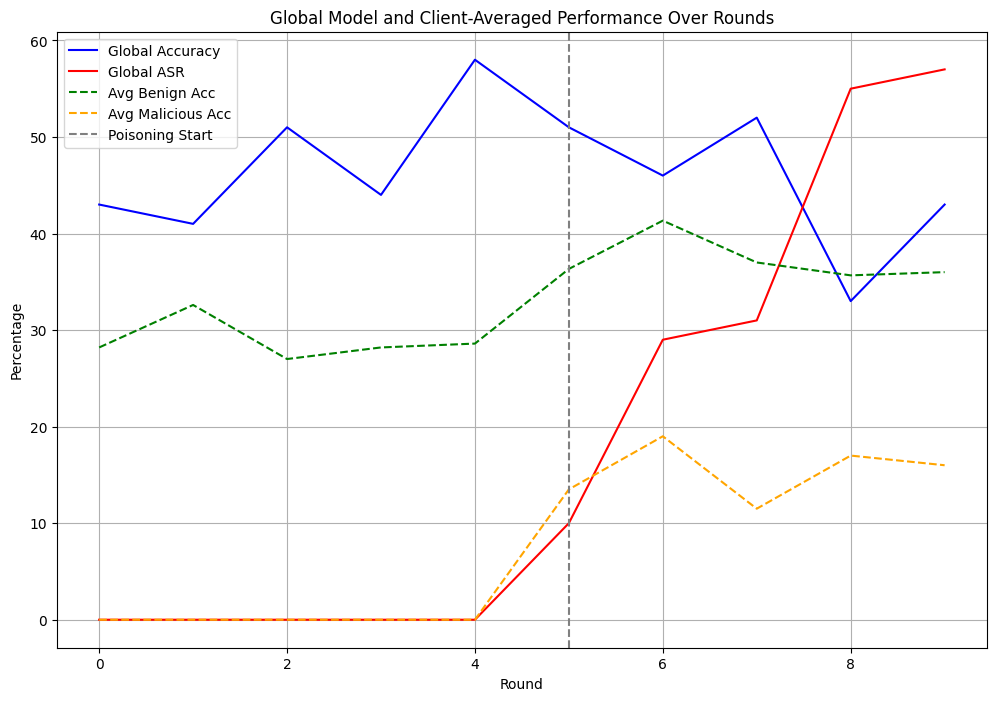

In [49]:
import torch
from torch import nn
from torchvision.models import mobilenet_v2
from matplotlib import pyplot as plt
# Federated Learning with Poisoning Experiment
import copy
import pandas as pd
import numpy as np

target_label = 8
poison_ratio = 0.9
mode = "trigger"  # or "trigger", edgecase
aggrigation_strategy = "FedAvg"


def run_federated_learning():
    # Initialize global model
    global_model = mobilenet_v2(pretrained=True)
    global_model.classifier[1] = nn.Linear(global_model.classifier[1].in_features, 10)
    global_model = global_model.to(device)

    # Simulate clients
    start_poison_round = 5
    num_clients = 5
    num_rounds = 10
    client_data_size = 40  # 200/5 samples per client

    # Lists to store metrics
    global_accs = []
    global_asrs = []
    metrics_data = []
    malicious_participation = []
    aggregated_metrics = []
    malicious_rounds = {0: 0, 2: 0}  # Track rounds for malicious clients

    # Create client datasets
    client_datasets = []
    for i in range(num_clients):
        start_idx = i * client_data_size
        end_idx = start_idx + client_data_size

        client_datasets.append(
            (train_data[start_idx:end_idx],
             train_labels[start_idx:end_idx])
        )

    # Federated learning rounds
    for round in range(num_rounds):
        print(f"\nRound {round + 1}/{num_rounds}")
        client_models = []
        round_malicious = []
        client_accs = []
        client_asrs = []

        # Train local models
        for client_id, (client_data, client_labels) in enumerate(client_datasets):
            # Initialize client model with global weights
            client_model = copy.deepcopy(global_model)

            # After round 5, poison data for clients 0 and 2
            is_malicious = round >= start_poison_round and (client_id == 0 or client_id == 2)
            if is_malicious:
                client_data, client_labels = trigger_or_edgecase_poison_strategy(
                    client_data,
                    client_labels,
                    mode=mode,
                    target_label=target_label,
                    poison_ratio=poison_ratio
                )
                round_malicious.append(client_id)
                malicious_rounds[client_id] += 1  # Increment rounds for malicious clients

            # Create client dataloader
            client_loader = torch.utils.data.DataLoader(
                list(zip(client_data, client_labels)),
                batch_size=32,
                shuffle=True
            )

            # Train client model 
            client_optimizer = torch.optim.Adam(client_model.parameters(), lr=0.001)
            train_model(client_model, client_loader, criterion, client_optimizer, epochs=2)

            # Evaluate client model
            test_loader = torch.utils.data.DataLoader(
                list(zip(test_data, test_labels)),
                batch_size=32,
                shuffle=False
            )
            client_acc = evaluate_model(client_model, test_loader)
            client_asr = evaluate_asr(client_model, triggered_test, test_labels, target_label)

            client_accs.append(client_acc)
            client_asrs.append(client_asr * 100)
            client_models.append(client_model)

        malicious_participation.append(round_malicious)

        # Aggregate models (FedAvg)
        if aggrigation_strategy == "FedAvg":
            global_dict = global_model.state_dict()
            for key in global_dict.keys():
                global_dict[key] = torch.stack(
                    [client_models[i].state_dict()[key].float() for i in range(num_clients)]
                ).mean(0)
            global_model.load_state_dict(global_dict)

        # Evaluate global model accuracy and ASR
        test_loader = torch.utils.data.DataLoader(
            list(zip(test_data, test_labels)),
            batch_size=32,
            shuffle=False
        )
        global_acc = evaluate_model(global_model, test_loader)
        global_asr = evaluate_asr(global_model, triggered_test, test_labels, target_label)

        global_accs.append(global_acc)
        global_asrs.append(global_asr * 100)  # Convert to percentage

        # Store metrics for CSV
        metrics_data.append({
            'round': round + 1,
            'accuracy': global_acc,
            'asr': global_asr * 100 if round >= start_poison_round else 0,
            'poisoning_active': 1 if round >= start_poison_round else 0,
            'malicious_clients': ','.join(map(str, round_malicious)),
            'benign_acc_avg': np.mean([acc for i, acc in enumerate(client_accs) if i not in round_malicious]),
            'malicious_acc_avg': np.mean(
                [acc for i, acc in enumerate(client_accs) if i in round_malicious]) if round_malicious else 0,
            'benign_asr_avg': np.mean([asr for i, asr in enumerate(client_asrs) if i not in round_malicious]),
            'malicious_asr_avg': np.mean(
                [asr for i, asr in enumerate(client_asrs) if i in round_malicious]) if round_malicious else 0
        })

        print(f"Global Model ACC: {global_acc:.2f}%")
        print(f"Global Model ASR: {global_asr:.2%}")
        print(f"Malicious clients in round {round + 1}: {round_malicious}")
        print(f"Average Benign Client ACC: {metrics_data[-1]['benign_acc_avg']:.2f}%")
        print(f"Average Malicious Client ACC: {metrics_data[-1]['malicious_acc_avg']:.2f}%")

    # Calculate AAR (Averaged Aggregated Rounds)
    total_rounds = sum(malicious_rounds.values())
    num_malicious = len(malicious_rounds)
    aar = total_rounds / num_malicious if num_malicious > 0 else 0
    print(f"\nAveraged Aggregated Rounds (AAR): {aar:.2f}")

    # Save metrics to CSV
    metrics_df = pd.DataFrame(metrics_data)
    metrics_df.to_csv('federated_metrics.csv', index=False)

    # Plot accuracy and ASR with client averages
    plt.figure(figsize=(12, 8))
    plt.plot(range(num_rounds), metrics_df['accuracy'], label='Global Accuracy', color='blue')
    plt.plot(range(num_rounds), metrics_df['asr'], label='Global ASR', color='red')
    plt.plot(range(num_rounds), metrics_df['benign_acc_avg'], label='Avg Benign Acc', color='green', linestyle='--')
    plt.plot(range(num_rounds), metrics_df['malicious_acc_avg'], label='Avg Malicious Acc', color='orange',
             linestyle='--')
    plt.axvline(x=5, color='gray', linestyle='--', label='Poisoning Start')
    plt.xlabel('Round')
    plt.ylabel('Percentage')
    plt.title('Global Model and Client-Averaged Performance Over Rounds')
    plt.legend()
    plt.grid(True)
    plt.show()


# Run federated learning experiment
run_federated_learning()



Round 1/300
Epoch 1: Loss = 2.0877, Accuracy = 20.00%
Epoch 2: Loss = 0.9425, Accuracy = 87.50%
Epoch 1: Loss = 2.1032, Accuracy = 17.50%
Epoch 2: Loss = 0.9513, Accuracy = 77.50%
Epoch 1: Loss = 2.4047, Accuracy = 22.50%
Epoch 2: Loss = 1.1855, Accuracy = 90.00%
Epoch 1: Loss = 2.3238, Accuracy = 12.50%
Epoch 2: Loss = 0.9018, Accuracy = 87.50%
Epoch 1: Loss = 2.4745, Accuracy = 7.50%
Epoch 2: Loss = 0.9936, Accuracy = 87.50%
Global Model ACC: 43.00%
Global Model ASR: 7.00%
Malicious clients in round 1: []
Average Benign Client ACC: 28.20%
Average Malicious Client ACC: 0.00%

Round 2/300
Epoch 1: Loss = 1.1897, Accuracy = 75.00%
Epoch 2: Loss = 0.4562, Accuracy = 87.50%
Epoch 1: Loss = 1.1418, Accuracy = 80.00%
Epoch 2: Loss = 0.1960, Accuracy = 97.50%
Epoch 1: Loss = 1.0821, Accuracy = 80.00%
Epoch 2: Loss = 0.5944, Accuracy = 90.00%
Epoch 1: Loss = 1.2093, Accuracy = 82.50%
Epoch 2: Loss = 0.2890, Accuracy = 100.00%
Epoch 1: Loss = 1.2359, Accuracy = 72.50%
Epoch 2: Loss = 0.5879, 

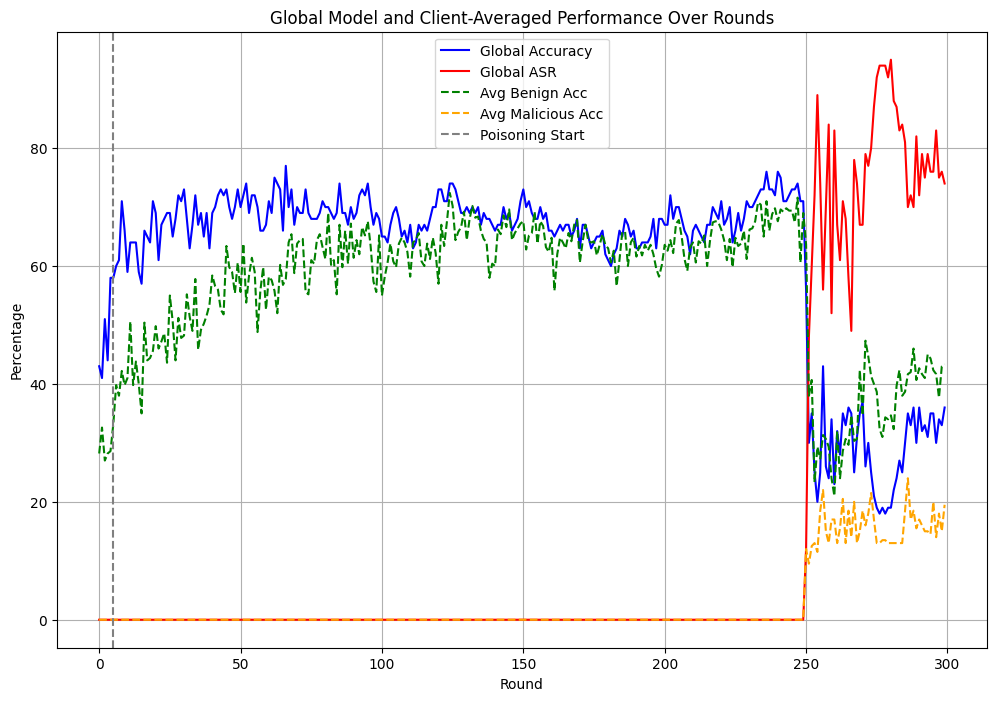

In [53]:
def fedavg(client_models):
    """
    Performs FedAvg aggregation on client models.
    
    Args:
        client_models (list): List of client models to aggregate
        
    Returns:
        dict: Aggregated model state dictionary
    """
    # Get state dict from first model as template
    global_dict = client_models[0].state_dict()

    # Average the parameters across all client models
    for key in global_dict.keys():
        global_dict[key] = torch.stack(
            [client_models[i].state_dict()[key].float() for i in range(len(client_models))]
        ).mean(0)

    return global_dict


def run_federated_learning():
    # Initialize global model  
    global_model = mobilenet_v2(pretrained=True)
    global_model.classifier[1] = nn.Linear(global_model.classifier[1].in_features, 10)
    global_model = global_model.to(device)

    # Simulate clients
    start_poison_round = 250
    num_clients = 5
    num_rounds = 300
    client_data_size = 40  # 200/5 samples per client

    # Lists to store metrics
    global_accs = []
    global_asrs = []
    metrics_data = []
    malicious_participation = []
    aggregated_metrics = []
    malicious_rounds = {0: 0, 2: 0}  # Track rounds for malicious clients

    # Create client datasets
    client_datasets = []
    for i in range(num_clients):
        start_idx = i * client_data_size
        end_idx = start_idx + client_data_size

        client_datasets.append(
            (train_data[start_idx:end_idx],
             train_labels[start_idx:end_idx])
        )

    # Federated learning rounds
    for round in range(num_rounds):
        print(f"\nRound {round + 1}/{num_rounds}")
        client_models = []
        round_malicious = []
        client_accs = []
        client_asrs = []

        # Train local models
        for client_id, (client_data, client_labels) in enumerate(client_datasets):
            # Initialize client model with global weights
            client_model = copy.deepcopy(global_model)

            # After round 5, poison data for clients 0 and 2
            is_malicious = round >= start_poison_round and (client_id == 0 or client_id == 2)
            if is_malicious:
                client_data, client_labels = trigger_or_edgecase_poison_strategy(
                    client_data,
                    client_labels,
                    mode=mode,
                    target_label=target_label,
                    poison_ratio=poison_ratio
                )
                round_malicious.append(client_id)
                malicious_rounds[client_id] += 1  # Increment rounds for malicious clients

            # Create client dataloader
            client_loader = torch.utils.data.DataLoader(
                list(zip(client_data, client_labels)),
                batch_size=32,
                shuffle=True
            )

            # Train client model 
            client_optimizer = torch.optim.Adam(client_model.parameters(), lr=0.001)
            train_model(client_model, client_loader, criterion, client_optimizer, epochs=2)

            # Evaluate client model
            test_loader = torch.utils.data.DataLoader(
                list(zip(test_data, test_labels)),
                batch_size=32,
                shuffle=False
            )
            client_acc = evaluate_model(client_model, test_loader)
            client_asr = evaluate_asr(client_model, triggered_test, test_labels, target_label)

            client_accs.append(client_acc)
            client_asrs.append(client_asr * 100)
            client_models.append(client_model)

        malicious_participation.append(round_malicious)

        # Aggregate models using FedAvg
        if aggrigation_strategy == "FedAvg":
            global_dict = fedavg(client_models)
            global_model.load_state_dict(global_dict)

        # Evaluate global model accuracy and ASR
        test_loader = torch.utils.data.DataLoader(
            list(zip(test_data, test_labels)),
            batch_size=32,
            shuffle=False
        )
        global_acc = evaluate_model(global_model, test_loader)
        global_asr = evaluate_asr(global_model, triggered_test, test_labels, target_label)

        global_accs.append(global_acc)
        global_asrs.append(global_asr * 100)  # Convert to percentage

        # Store metrics for CSV
        metrics_data.append({
            'round': round + 1,
            'accuracy': global_acc,
            'asr': global_asr * 100 if round >= start_poison_round else 0,
            'poisoning_active': 1 if round >= start_poison_round else 0,
            'malicious_clients': ','.join(map(str, round_malicious)),
            'benign_acc_avg': np.mean([acc for i, acc in enumerate(client_accs) if i not in round_malicious]),
            'malicious_acc_avg': np.mean(
                [acc for i, acc in enumerate(client_accs) if i in round_malicious]) if round_malicious else 0,
            'benign_asr_avg': np.mean([asr for i, asr in enumerate(client_asrs) if i not in round_malicious]),
            'malicious_asr_avg': np.mean(
                [asr for i, asr in enumerate(client_asrs) if i in round_malicious]) if round_malicious else 0
        })

        print(f"Global Model ACC: {global_acc:.2f}%")
        print(f"Global Model ASR: {global_asr:.2%}")
        print(f"Malicious clients in round {round + 1}: {round_malicious}")
        print(f"Average Benign Client ACC: {metrics_data[-1]['benign_acc_avg']:.2f}%")
        print(f"Average Malicious Client ACC: {metrics_data[-1]['malicious_acc_avg']:.2f}%")

    # Calculate AAR (Averaged Aggregated Rounds)
    total_rounds = sum(malicious_rounds.values())
    num_malicious = len(malicious_rounds)
    aar = total_rounds / num_malicious if num_malicious > 0 else 0
    print(f"\nAveraged Aggregated Rounds (AAR): {aar:.2f}")

    # Save metrics to CSV
    metrics_df = pd.DataFrame(metrics_data)
    metrics_df.to_csv('federated_metrics.csv', index=False)

    # Plot accuracy and ASR with client averages
    plt.figure(figsize=(12, 8))
    plt.plot(range(num_rounds), metrics_df['accuracy'], label='Global Accuracy', color='blue')
    plt.plot(range(num_rounds), metrics_df['asr'], label='Global ASR', color='red')
    plt.plot(range(num_rounds), metrics_df['benign_acc_avg'], label='Avg Benign Acc', color='green', linestyle='--')
    plt.plot(range(num_rounds), metrics_df['malicious_acc_avg'], label='Avg Malicious Acc', color='orange',
             linestyle='--')
    plt.axvline(x=5, color='gray', linestyle='--', label='Poisoning Start')
    plt.xlabel('Round')
    plt.ylabel('Percentage')
    plt.title('Global Model and Client-Averaged Performance Over Rounds')
    plt.legend()
    plt.grid(True)
    plt.show()


# Run federated learning experiment
run_federated_learning()


# Aggrigation strategies

In [ ]:
def fedavg(client_models):
    """
    Performs FedAvg aggregation on client models.

    Args:
        client_models (list): List of client models to aggregate

    Returns:
        dict: Aggregated model state dictionary
    """
    # Get state dict from first model as template
    global_dict = client_models[0].state_dict()

    # Average the parameters across all client models
    for key in global_dict.keys():
        global_dict[key] = torch.stack(
            [client_models[i].state_dict()[key].float() for i in range(len(client_models))]
        ).mean(0)

    return global_dict


def fedmedian(client_models):
    """
    Performs median-based aggregation on client models.

    Args:
        client_models (list): List of client models to aggregate

    Returns:
        dict: Aggregated model state dictionary using median values
    """
    global_dict = client_models[0].state_dict()

    for key in global_dict.keys():
        stacked_params = torch.stack([model.state_dict()[key].float() for model in client_models])
        global_dict[key] = torch.median(stacked_params, dim=0)[0]

    return global_dict


def trimmed_mean(client_models, beta=0.1):
    """
    Performs trimmed mean aggregation by removing beta fraction of largest and smallest values.

    Args:
        client_models (list): List of client models to aggregate
        beta (float): Fraction of values to trim from each end (default 0.1)

    Returns:
        dict: Aggregated model state dictionary using trimmed mean
    """
    global_dict = client_models[0].state_dict()
    n_models = len(client_models)
    n_trim = int(beta * n_models)

    for key in global_dict.keys():
        stacked_params = torch.stack([model.state_dict()[key].float() for model in client_models])
        sorted_params = torch.sort(stacked_params, dim=0)[0]

        if n_trim > 0:
            trimmed_params = sorted_params[n_trim:-n_trim]
        else:
            trimmed_params = sorted_params

        global_dict[key] = torch.mean(trimmed_params, dim=0)

    return global_dict


def krum(client_models, f):
    """
    Implements Krum aggregation - selects parameter vector with minimum sum of distances to closest n-f-2 vectors.

    Args:
        client_models (list): List of client models to aggregate
        f (int): Number of Byzantine workers to defend against

    Returns:
        dict: Aggregated model state dictionary using Krum
    """
    global_dict = client_models[0].state_dict()
    n = len(client_models)

    for key in global_dict.keys():
        # Stack parameters from all models
        stacked_params = torch.stack([model.state_dict()[key].float() for model in client_models])

        # Calculate pairwise distances between parameter vectors
        distances = torch.cdist(stacked_params.view(n, -1), stacked_params.view(n, -1))

        # For each model, sum distances to n-f-2 closest other models
        scores = []
        for i in range(n):
            dist_i = distances[i]
            # Get indices of n-f-2 smallest distances, excluding distance to self
            closest_idx = torch.argsort(dist_i)[1:n - f - 2]
            scores.append(torch.sum(dist_i[closest_idx]))

        # Select model with minimum score
        selected_idx = torch.argmin(torch.tensor(scores))
        global_dict[key] = client_models[selected_idx].state_dict()[key].float()

    return global_dict


In [0]:


def run_federated_learning():
    # Initialize global model
    global_model = mobilenet_v2(pretrained=True)
    global_model.classifier[1] = nn.Linear(global_model.classifier[1].in_features, 10)
    global_model = global_model.to(device)

    # Simulate clients
    aggrigation_strategy = "Krum"
    start_poison_round = 60
    num_clients = 5
    num_rounds = 100
    client_data_size = 40  # 200/5 samples per client

    # Lists to store metrics
    global_accs = []
    global_asrs = []
    metrics_data = []
    malicious_participation = []
    aggregated_metrics = []
    malicious_rounds = {0: 0, 2: 0}  # Track rounds for malicious clients

    # Create client datasets
    client_datasets = []
    for i in range(num_clients):
        start_idx = i * client_data_size
        end_idx = start_idx + client_data_size

        client_datasets.append(
            (train_data[start_idx:end_idx],
             train_labels[start_idx:end_idx])
        )

    # Federated learning rounds
    for round in range(num_rounds):
        print(f"\nRound {round + 1}/{num_rounds}")
        client_models = []
        round_malicious = []
        client_accs = []
        client_asrs = []

        # Train local models
        for client_id, (client_data, client_labels) in enumerate(client_datasets):
            # Initialize client model with global weights
            client_model = copy.deepcopy(global_model)

            # After round 5, poison data for clients 0 and 2
            is_malicious = round >= start_poison_round and (client_id == 0 or client_id == 2)
            if is_malicious:
                client_data, client_labels = trigger_or_edgecase_poison_strategy(
                    client_data,
                    client_labels,
                    mode=mode,
                    target_label=target_label,
                    poison_ratio=poison_ratio
                )
                round_malicious.append(client_id)
                malicious_rounds[client_id] += 1  # Increment rounds for malicious clients

            # Create client dataloader
            client_loader = torch.utils.data.DataLoader(
                list(zip(client_data, client_labels)),
                batch_size=32,
                shuffle=True
            )

            # Train client model
            client_optimizer = torch.optim.Adam(client_model.parameters(), lr=0.001)
            train_model(client_model, client_loader, criterion, client_optimizer, epochs=2)

            # Evaluate client model
            test_loader = torch.utils.data.DataLoader(
                list(zip(test_data, test_labels)),
                batch_size=32,
                shuffle=False
            )
            client_acc = evaluate_model(client_model, test_loader)
            client_asr = evaluate_asr(client_model, triggered_test, test_labels, target_label)

            client_accs.append(client_acc)
            client_asrs.append(client_asr * 100)
            client_models.append(client_model)

        malicious_participation.append(round_malicious)

        # Aggregate models using FedAvg
        if aggrigation_strategy == "FedAvg":
            global_dict = fedavg(client_models)
        elif aggrigation_strategy == "FedMedian":
            global_dict = fedmedian(client_models)
        elif aggrigation_strategy == "TrimmedMean":
            global_dict = trimmed_mean(client_models)
        elif aggrigation_strategy == "Krum":
            global_dict = krum(client_models, f=3)
        else:
            raise ValueError("Invalid aggregation strategy")

        global_model.load_state_dict(global_dict)

        # Evaluate global model accuracy and ASR
        test_loader = torch.utils.data.DataLoader(
            list(zip(test_data, test_labels)),
            batch_size=32,
            shuffle=False
        )
        global_acc = evaluate_model(global_model, test_loader)
        global_asr = evaluate_asr(global_model, triggered_test, test_labels, target_label)

        global_accs.append(global_acc)
        global_asrs.append(global_asr * 100)  # Convert to percentage

        # Store metrics for CSV
        metrics_data.append({
            'round': round + 1,
            'accuracy': global_acc,
            'asr': global_asr * 100 if round >= start_poison_round else 0,
            'poisoning_active': 1 if round >= start_poison_round else 0,
            'malicious_clients': ','.join(map(str, round_malicious)),
            'benign_acc_avg': np.mean([acc for i, acc in enumerate(client_accs) if i not in round_malicious]),
            'malicious_acc_avg': np.mean(
                [acc for i, acc in enumerate(client_accs) if i in round_malicious]) if round_malicious else 0,
            'benign_asr_avg': np.mean([asr for i, asr in enumerate(client_asrs) if i not in round_malicious]),
            'malicious_asr_avg': np.mean(
                [asr for i, asr in enumerate(client_asrs) if i in round_malicious]) if round_malicious else 0
        })

        print(f"Global Model ACC: {global_acc:.2f}%")
        print(f"Global Model ASR: {global_asr:.2%}")
        print(f"Malicious clients in round {round + 1}: {round_malicious}")
        print(f"Average Benign Client ACC: {metrics_data[-1]['benign_acc_avg']:.2f}%")
        print(f"Average Malicious Client ACC: {metrics_data[-1]['malicious_acc_avg']:.2f}%")

    # Calculate AAR (Averaged Aggregated Rounds)
    total_rounds = sum(malicious_rounds.values())
    num_malicious = len(malicious_rounds)
    aar = total_rounds / num_malicious if num_malicious > 0 else 0
    print(f"\nAveraged Aggregated Rounds (AAR): {aar:.2f}")

    # Save metrics to CSV
    metrics_df = pd.DataFrame(metrics_data)
    metrics_df.to_csv('federated_metrics.csv', index=False)

    # Plot accuracy and ASR with client averages
    plt.figure(figsize=(12, 8))
    plt.plot(range(num_rounds), metrics_df['accuracy'], label='Global Accuracy', color='blue')
    plt.plot(range(num_rounds), metrics_df['asr'], label='Global ASR', color='red')
    plt.plot(range(num_rounds), metrics_df['benign_acc_avg'], label='Avg Benign Acc', color='green', linestyle='--')
    plt.plot(range(num_rounds), metrics_df['malicious_acc_avg'], label='Avg Malicious Acc', color='orange',
             linestyle='--')
    plt.axvline(x=5, color='gray', linestyle='--', label='Poisoning Start')
    plt.xlabel('Round')
    plt.ylabel('Percentage')
    plt.title('Global Model and Client-Averaged Performance Over Rounds')
    plt.legend()
    plt.grid(True)
    plt.show()


# Run federated learning experiment
run_federated_learning()


In [ ]:


def run_federated_learning():
    # Initialize global model
    global_model = mobilenet_v2(pretrained=True)
    global_model.classifier[1] = nn.Linear(global_model.classifier[1].in_features, 10)
    global_model = global_model.to(device)

    # Simulate clients
    aggrigation_strategy = "TrimmedMean"
    start_poison_round = 60
    num_clients = 5
    num_rounds = 100
    client_data_size = 40  # 200/5 samples per client

    # Lists to store metrics
    global_accs = []
    global_asrs = []
    metrics_data = []
    malicious_participation = []
    aggregated_metrics = []
    malicious_rounds = {0: 0, 2: 0}  # Track rounds for malicious clients

    # Create client datasets
    client_datasets = []
    for i in range(num_clients):
        start_idx = i * client_data_size
        end_idx = start_idx + client_data_size

        client_datasets.append(
            (train_data[start_idx:end_idx],
             train_labels[start_idx:end_idx])
        )

    # Federated learning rounds
    for round in range(num_rounds):
        print(f"\nRound {round + 1}/{num_rounds}")
        client_models = []
        round_malicious = []
        client_accs = []
        client_asrs = []

        # Train local models
        for client_id, (client_data, client_labels) in enumerate(client_datasets):
            # Initialize client model with global weights
            client_model = copy.deepcopy(global_model)

            # After round 5, poison data for clients 0 and 2
            is_malicious = round >= start_poison_round and (client_id == 0 or client_id == 2)
            if is_malicious:
                client_data, client_labels = trigger_or_edgecase_poison_strategy(
                    client_data,
                    client_labels,
                    mode=mode,
                    target_label=target_label,
                    poison_ratio=poison_ratio
                )
                round_malicious.append(client_id)
                malicious_rounds[client_id] += 1  # Increment rounds for malicious clients

            # Create client dataloader
            client_loader = torch.utils.data.DataLoader(
                list(zip(client_data, client_labels)),
                batch_size=32,
                shuffle=True
            )

            # Train client model
            client_optimizer = torch.optim.Adam(client_model.parameters(), lr=0.001)
            train_model(client_model, client_loader, criterion, client_optimizer, epochs=2)

            # Evaluate client model
            test_loader = torch.utils.data.DataLoader(
                list(zip(test_data, test_labels)),
                batch_size=32,
                shuffle=False
            )
            client_acc = evaluate_model(client_model, test_loader)
            client_asr = evaluate_asr(client_model, triggered_test, test_labels, target_label)

            client_accs.append(client_acc)
            client_asrs.append(client_asr * 100)
            client_models.append(client_model)

        malicious_participation.append(round_malicious)

        # Aggregate models using FedAvg
        if aggrigation_strategy == "FedAvg":
            global_dict = fedavg(client_models)
        elif aggrigation_strategy == "FedMedian":
            global_dict = fedmedian(client_models)
        elif aggrigation_strategy == "TrimmedMean":
            global_dict = trimmed_mean(client_models)
        elif aggrigation_strategy == "Krum":
            global_dict = krum(client_models, f=3)
        else:
            raise ValueError("Invalid aggregation strategy")

        global_model.load_state_dict(global_dict)

        # Evaluate global model accuracy and ASR
        test_loader = torch.utils.data.DataLoader(
            list(zip(test_data, test_labels)),
            batch_size=32,
            shuffle=False
        )
        global_acc = evaluate_model(global_model, test_loader)
        global_asr = evaluate_asr(global_model, triggered_test, test_labels, target_label)

        global_accs.append(global_acc)
        global_asrs.append(global_asr * 100)  # Convert to percentage

        # Store metrics for CSV
        metrics_data.append({
            'round': round + 1,
            'accuracy': global_acc,
            'asr': global_asr * 100 if round >= start_poison_round else 0,
            'poisoning_active': 1 if round >= start_poison_round else 0,
            'malicious_clients': ','.join(map(str, round_malicious)),
            'benign_acc_avg': np.mean([acc for i, acc in enumerate(client_accs) if i not in round_malicious]),
            'malicious_acc_avg': np.mean(
                [acc for i, acc in enumerate(client_accs) if i in round_malicious]) if round_malicious else 0,
            'benign_asr_avg': np.mean([asr for i, asr in enumerate(client_asrs) if i not in round_malicious]),
            'malicious_asr_avg': np.mean(
                [asr for i, asr in enumerate(client_asrs) if i in round_malicious]) if round_malicious else 0
        })

        print(f"Global Model ACC: {global_acc:.2f}%")
        print(f"Global Model ASR: {global_asr:.2%}")
        print(f"Malicious clients in round {round + 1}: {round_malicious}")
        print(f"Average Benign Client ACC: {metrics_data[-1]['benign_acc_avg']:.2f}%")
        print(f"Average Malicious Client ACC: {metrics_data[-1]['malicious_acc_avg']:.2f}%")

    # Calculate AAR (Averaged Aggregated Rounds)
    total_rounds = sum(malicious_rounds.values())
    num_malicious = len(malicious_rounds)
    aar = total_rounds / num_malicious if num_malicious > 0 else 0
    print(f"\nAveraged Aggregated Rounds (AAR): {aar:.2f}")

    # Save metrics to CSV
    metrics_df = pd.DataFrame(metrics_data)
    metrics_df.to_csv('federated_metrics.csv', index=False)

    # Plot accuracy and ASR with client averages
    plt.figure(figsize=(12, 8))
    plt.plot(range(num_rounds), metrics_df['accuracy'], label='Global Accuracy', color='blue')
    plt.plot(range(num_rounds), metrics_df['asr'], label='Global ASR', color='red')
    plt.plot(range(num_rounds), metrics_df['benign_acc_avg'], label='Avg Benign Acc', color='green', linestyle='--')
    plt.plot(range(num_rounds), metrics_df['malicious_acc_avg'], label='Avg Malicious Acc', color='orange',
             linestyle='--')
    plt.axvline(x=5, color='gray', linestyle='--', label='Poisoning Start')
    plt.xlabel('Round')
    plt.ylabel('Percentage')
    plt.title('Global Model and Client-Averaged Performance Over Rounds')
    plt.legend()
    plt.grid(True)
    plt.show()


# Run federated learning experiment
run_federated_learning()


In [ ]:


def run_federated_learning():
    # Initialize global model
    global_model = mobilenet_v2(pretrained=True)
    global_model.classifier[1] = nn.Linear(global_model.classifier[1].in_features, 10)
    global_model = global_model.to(device)

    # Simulate clients
    aggrigation_strategy = "FedMedian"
    start_poison_round = 60
    num_clients = 5
    num_rounds = 100
    client_data_size = 40  # 200/5 samples per client

    # Lists to store metrics
    global_accs = []
    global_asrs = []
    metrics_data = []
    malicious_participation = []
    aggregated_metrics = []
    malicious_rounds = {0: 0, 2: 0}  # Track rounds for malicious clients

    # Create client datasets
    client_datasets = []
    for i in range(num_clients):
        start_idx = i * client_data_size
        end_idx = start_idx + client_data_size

        client_datasets.append(
            (train_data[start_idx:end_idx],
             train_labels[start_idx:end_idx])
        )

    # Federated learning rounds
    for round in range(num_rounds):
        print(f"\nRound {round + 1}/{num_rounds}")
        client_models = []
        round_malicious = []
        client_accs = []
        client_asrs = []

        # Train local models
        for client_id, (client_data, client_labels) in enumerate(client_datasets):
            # Initialize client model with global weights
            client_model = copy.deepcopy(global_model)

            # After round 5, poison data for clients 0 and 2
            is_malicious = round >= start_poison_round and (client_id == 0 or client_id == 2)
            if is_malicious:
                client_data, client_labels = trigger_or_edgecase_poison_strategy(
                    client_data,
                    client_labels,
                    mode=mode,
                    target_label=target_label,
                    poison_ratio=poison_ratio
                )
                round_malicious.append(client_id)
                malicious_rounds[client_id] += 1  # Increment rounds for malicious clients

            # Create client dataloader
            client_loader = torch.utils.data.DataLoader(
                list(zip(client_data, client_labels)),
                batch_size=32,
                shuffle=True
            )

            # Train client model
            client_optimizer = torch.optim.Adam(client_model.parameters(), lr=0.001)
            train_model(client_model, client_loader, criterion, client_optimizer, epochs=2)

            # Evaluate client model
            test_loader = torch.utils.data.DataLoader(
                list(zip(test_data, test_labels)),
                batch_size=32,
                shuffle=False
            )
            client_acc = evaluate_model(client_model, test_loader)
            client_asr = evaluate_asr(client_model, triggered_test, test_labels, target_label)

            client_accs.append(client_acc)
            client_asrs.append(client_asr * 100)
            client_models.append(client_model)

        malicious_participation.append(round_malicious)

        # Aggregate models using FedAvg
        if aggrigation_strategy == "FedAvg":
            global_dict = fedavg(client_models)
        elif aggrigation_strategy == "FedMedian":
            global_dict = fedmedian(client_models)
        elif aggrigation_strategy == "TrimmedMean":
            global_dict = trimmed_mean(client_models)
        elif aggrigation_strategy == "Krum":
            global_dict = krum(client_models, f=3)
        else:
            raise ValueError("Invalid aggregation strategy")

        global_model.load_state_dict(global_dict)

        # Evaluate global model accuracy and ASR
        test_loader = torch.utils.data.DataLoader(
            list(zip(test_data, test_labels)),
            batch_size=32,
            shuffle=False
        )
        global_acc = evaluate_model(global_model, test_loader)
        global_asr = evaluate_asr(global_model, triggered_test, test_labels, target_label)

        global_accs.append(global_acc)
        global_asrs.append(global_asr * 100)  # Convert to percentage

        # Store metrics for CSV
        metrics_data.append({
            'round': round + 1,
            'accuracy': global_acc,
            'asr': global_asr * 100 if round >= start_poison_round else 0,
            'poisoning_active': 1 if round >= start_poison_round else 0,
            'malicious_clients': ','.join(map(str, round_malicious)),
            'benign_acc_avg': np.mean([acc for i, acc in enumerate(client_accs) if i not in round_malicious]),
            'malicious_acc_avg': np.mean(
                [acc for i, acc in enumerate(client_accs) if i in round_malicious]) if round_malicious else 0,
            'benign_asr_avg': np.mean([asr for i, asr in enumerate(client_asrs) if i not in round_malicious]),
            'malicious_asr_avg': np.mean(
                [asr for i, asr in enumerate(client_asrs) if i in round_malicious]) if round_malicious else 0
        })

        print(f"Global Model ACC: {global_acc:.2f}%")
        print(f"Global Model ASR: {global_asr:.2%}")
        print(f"Malicious clients in round {round + 1}: {round_malicious}")
        print(f"Average Benign Client ACC: {metrics_data[-1]['benign_acc_avg']:.2f}%")
        print(f"Average Malicious Client ACC: {metrics_data[-1]['malicious_acc_avg']:.2f}%")

    # Calculate AAR (Averaged Aggregated Rounds)
    total_rounds = sum(malicious_rounds.values())
    num_malicious = len(malicious_rounds)
    aar = total_rounds / num_malicious if num_malicious > 0 else 0
    print(f"\nAveraged Aggregated Rounds (AAR): {aar:.2f}")

    # Save metrics to CSV
    metrics_df = pd.DataFrame(metrics_data)
    metrics_df.to_csv('federated_metrics.csv', index=False)

    # Plot accuracy and ASR with client averages
    plt.figure(figsize=(12, 8))
    plt.plot(range(num_rounds), metrics_df['accuracy'], label='Global Accuracy', color='blue')
    plt.plot(range(num_rounds), metrics_df['asr'], label='Global ASR', color='red')
    plt.plot(range(num_rounds), metrics_df['benign_acc_avg'], label='Avg Benign Acc', color='green', linestyle='--')
    plt.plot(range(num_rounds), metrics_df['malicious_acc_avg'], label='Avg Malicious Acc', color='orange',
             linestyle='--')
    plt.axvline(x=5, color='gray', linestyle='--', label='Poisoning Start')
    plt.xlabel('Round')
    plt.ylabel('Percentage')
    plt.title('Global Model and Client-Averaged Performance Over Rounds')
    plt.legend()
    plt.grid(True)
    plt.show()


# Run federated learning experiment
run_federated_learning()



Running experiment with FedAvg strategy...

Round 1/300


/home/abdenour/miniconda3/envs/FedREDefense/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/abdenour/miniconda3/envs/FedREDefense/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Global Model ACC: 64.00%
Global Model ASR: 7.00%
Malicious clients in round 1: []

Round 2/300
Global Model ACC: 82.00%
Global Model ASR: 13.00%
Malicious clients in round 2: []

Round 3/300
Global Model ACC: 79.00%
Global Model ASR: 13.00%
Malicious clients in round 3: []

Round 4/300
Global Model ACC: 75.00%
Global Model ASR: 13.00%
Malicious clients in round 4: []

Round 5/300
Global Model ACC: 83.00%
Global Model ASR: 16.00%
Malicious clients in round 5: []

Round 6/300
Global Model ACC: 78.00%
Global Model ASR: 9.00%
Malicious clients in round 6: []

Round 7/300
Global Model ACC: 79.00%
Global Model ASR: 13.00%
Malicious clients in round 7: []

Round 8/300
Global Model ACC: 77.00%
Global Model ASR: 14.00%
Malicious clients in round 8: []

Round 9/300
Global Model ACC: 84.00%
Global Model ASR: 14.00%
Malicious clients in round 9: []

Round 10/300
Global Model ACC: 78.00%
Global Model ASR: 12.00%
Malicious clients in round 10: []

Round 11/300
Global Model ACC: 78.00%
Global Model A

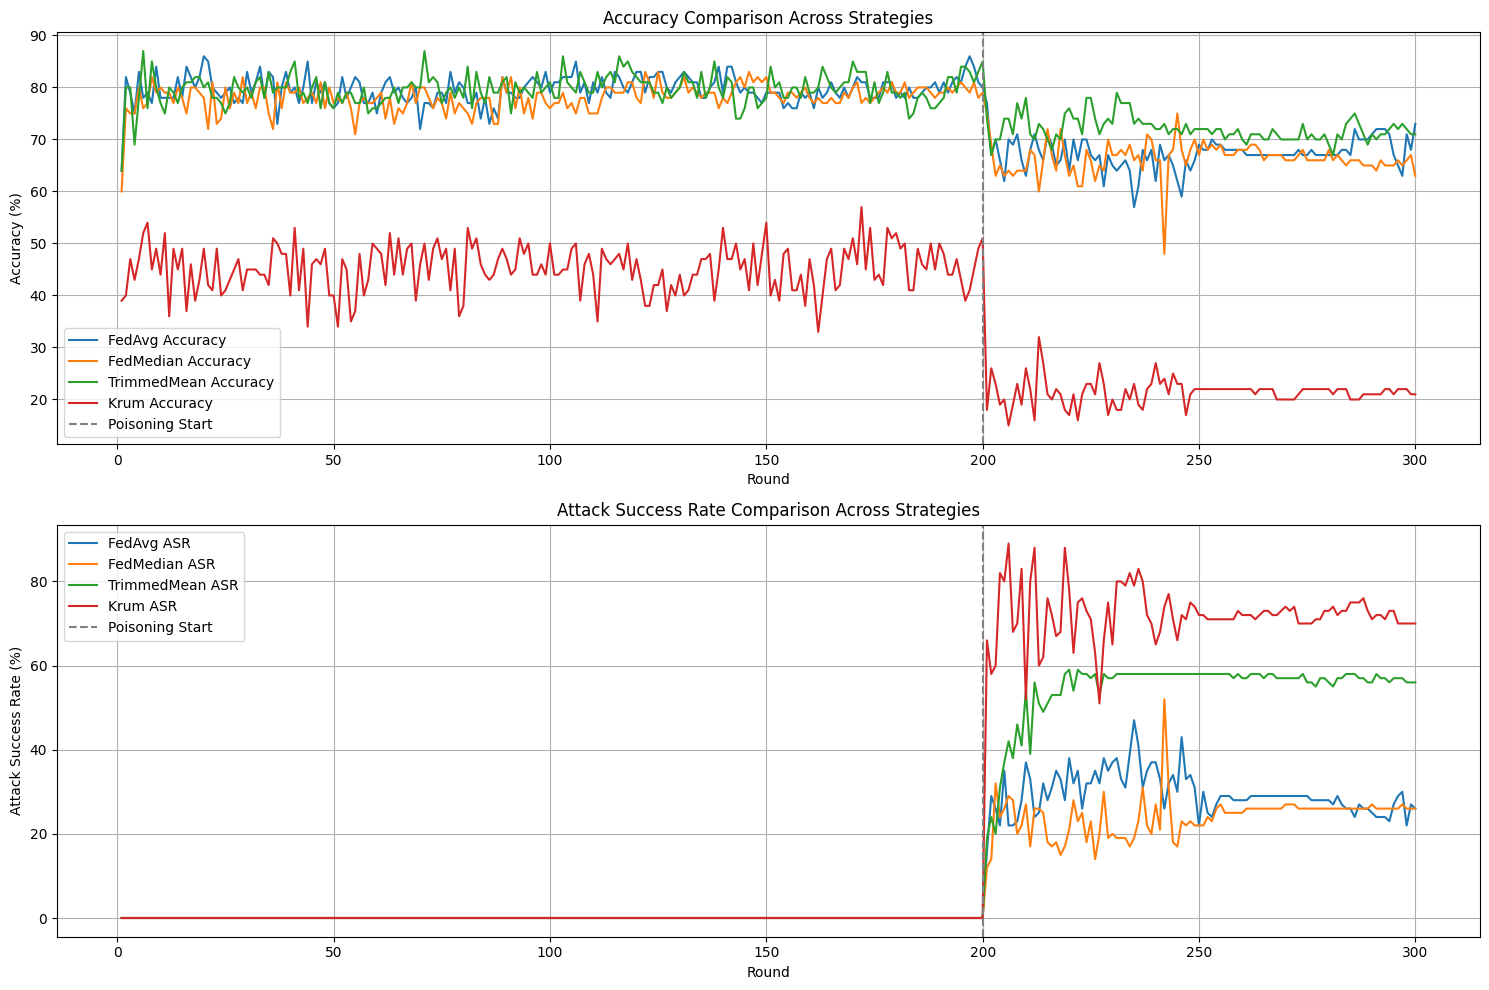

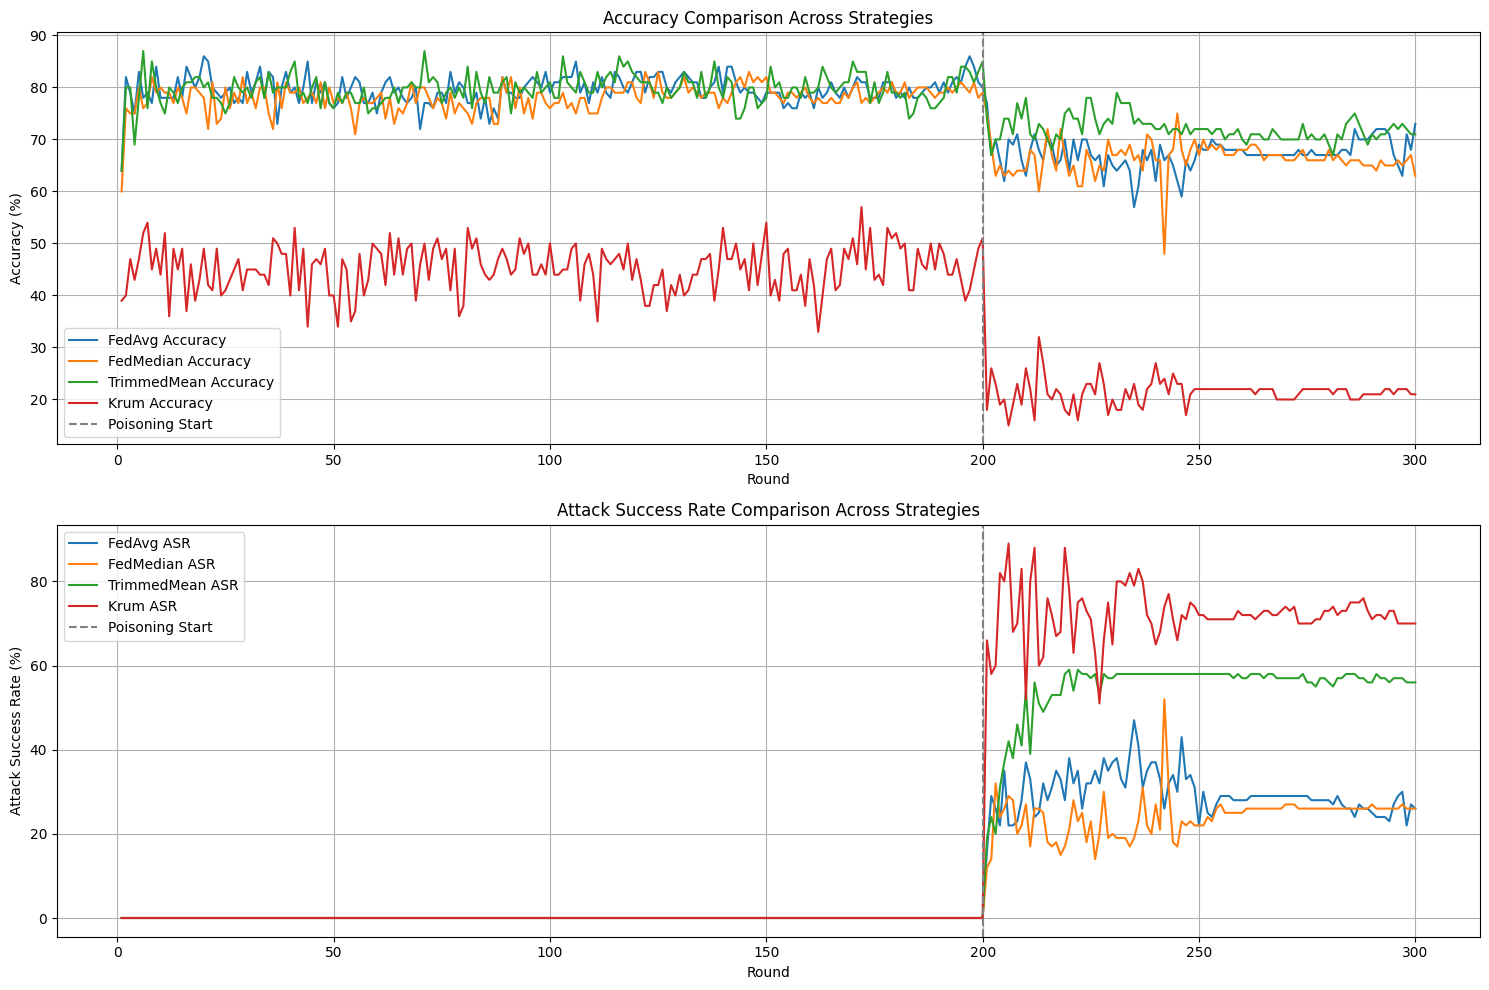

In [84]:
# Run experiments for all strategies
strategies = ["FedAvg", "FedMedian", "TrimmedMean", "Krum"]
all_metrics = {}

for strategy in strategies:
    aggrigation_strategy = strategy
    print(f"\nRunning experiment with {strategy} strategy...")

    metrics_data = []  # Reset metrics for new strategy

    # Initialize global model 
    global_model = mobilenet_v2(pretrained=True)
    global_model.classifier[1] = nn.Linear(global_model.classifier[1].in_features, 10)
    global_model = global_model.to(device)

    # Simulate clients
    start_poison_round = 200
    num_clients = 5
    num_rounds = 300
    client_data_size = 200  # 200/5 samples per client

    # Lists to store metrics
    global_accs = []
    global_asrs = []
    malicious_participation = []
    aggregated_metrics = []
    malicious_rounds = {0: 0, 2: 0}  # Track rounds for malicious clients

    # Create client datasets
    client_datasets = []
    for i in range(num_clients):
        start_idx = i * client_data_size
        end_idx = start_idx + client_data_size

        client_datasets.append(
            (train_data[start_idx:end_idx],
             train_labels[start_idx:end_idx])
        )

    # Federated learning rounds
    for round in range(num_rounds):
        print(f"\nRound {round + 1}/{num_rounds}")
        client_models = []
        round_malicious = []
        client_accs = []
        client_asrs = []

        # Train local models
        for client_id, (client_data, client_labels) in enumerate(client_datasets):
            # Initialize client model with global weights
            client_model = copy.deepcopy(global_model)

            # After round 5, poison data for clients 0 and 2  
            is_malicious = round >= start_poison_round and (client_id == 0 or client_id == 2)
            if is_malicious:
                client_data, client_labels = trigger_or_edgecase_poison_strategy(
                    client_data,
                    client_labels,
                    mode=mode,
                    target_label=target_label,
                    poison_ratio=poison_ratio
                )
                round_malicious.append(client_id)
                malicious_rounds[client_id] += 1  # Increment rounds for malicious clients

            # Create client dataloader
            client_loader = torch.utils.data.DataLoader(
                list(zip(client_data, client_labels)),
                batch_size=32,
                shuffle=True
            )

            # Train client model
            client_optimizer = torch.optim.Adam(client_model.parameters(), lr=0.001)
            train_model(client_model, client_loader, criterion, client_optimizer, epochs=2)

            # Evaluate client model
            test_loader = torch.utils.data.DataLoader(
                list(zip(test_data, test_labels)),
                batch_size=32,
                shuffle=False
            )
            client_acc = evaluate_model(client_model, test_loader)
            client_asr = evaluate_asr(client_model, triggered_test, test_labels, target_label)

            client_accs.append(client_acc)
            client_asrs.append(client_asr * 100)
            client_models.append(client_model)

        malicious_participation.append(round_malicious)

        # Aggregate models using selected strategy
        if aggrigation_strategy == "FedAvg":
            global_dict = fedavg(client_models)
        elif aggrigation_strategy == "FedMedian":
            global_dict = fedmedian(client_models)
        elif aggrigation_strategy == "TrimmedMean":
            global_dict = trimmed_mean(client_models)
        elif aggrigation_strategy == "Krum":
            global_dict = krum(client_models, f=3)

        global_model.load_state_dict(global_dict)

        # Evaluate global model
        test_loader = torch.utils.data.DataLoader(
            list(zip(test_data, test_labels)),
            batch_size=32,
            shuffle=False
        )
        global_acc = evaluate_model(global_model, test_loader)
        global_asr = evaluate_asr(global_model, triggered_test, test_labels, target_label)

        global_accs.append(global_acc)
        global_asrs.append(global_asr * 100)

        # Store metrics for CSV
        metrics_data.append({
            'round': round + 1,
            'accuracy': global_acc,
            'asr': global_asr * 100 if round >= start_poison_round else 0,
            'poisoning_active': 1 if round >= start_poison_round else 0,
            'malicious_clients': ','.join(map(str, round_malicious)),
            'benign_acc_avg': np.mean([acc for i, acc in enumerate(client_accs) if i not in round_malicious]),
            'malicious_acc_avg': np.mean(
                [acc for i, acc in enumerate(client_accs) if i in round_malicious]) if round_malicious else 0,
            'benign_asr_avg': np.mean([asr for i, asr in enumerate(client_asrs) if i not in round_malicious]),
            'malicious_asr_avg': np.mean(
                [asr for i, asr in enumerate(client_asrs) if i in round_malicious]) if round_malicious else 0,
            'strategy': strategy
        })

        print(f"Global Model ACC: {global_acc:.2f}%")
        print(f"Global Model ASR: {global_asr:.2%}")
        print(f"Malicious clients in round {round + 1}: {round_malicious}")

    all_metrics[strategy] = pd.DataFrame(metrics_data)

# Combine all metrics and save to CSV
combined_metrics = pd.concat(all_metrics.values())
combined_metrics.to_csv('federated_metrics_all_strategies.csv', index=False)

# Plot comparison of strategies
plt.figure(figsize=(15, 10))

# Plot accuracies
plt.subplot(2, 1, 1)
for strategy in strategies:
    plt.plot(all_metrics[strategy]['round'], all_metrics[strategy]['accuracy'],
             label=f'{strategy} Accuracy')
plt.axvline(x=start_poison_round, color='gray', linestyle='--', label='Poisoning Start')
plt.xlabel('Round')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison Across Strategies')
plt.legend()
plt.grid(True)

# Plot ASR
plt.subplot(2, 1, 2)
for strategy in strategies:
    plt.plot(all_metrics[strategy]['round'], all_metrics[strategy]['asr'],
             label=f'{strategy} ASR')
plt.axvline(x=start_poison_round, color='gray', linestyle='--', label='Poisoning Start')
plt.xlabel('Round')
plt.ylabel('Attack Success Rate (%)')
plt.title('Attack Success Rate Comparison Across Strategies')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

import json

# Create json from metrics
strategies_data = {}
for strategy in strategies:
    strategies_data[strategy] = {
        'accuracy': all_metrics[strategy]['accuracy'].tolist(),
        'asr': all_metrics[strategy]['asr'].tolist(),
        'rounds': all_metrics[strategy]['round'].tolist()
    }

# Save to JSON file
with open('strategies_metrics.json', 'w') as f:
    json.dump(strategies_data, f)

# Load from JSON and plot
with open('strategies_metrics.json', 'r') as f:
    loaded_data = json.load(f)

# Plot comparison of strategies
plt.figure(figsize=(15, 10))

# Plot accuracies
plt.subplot(2, 1, 1)
for strategy in strategies:
    plt.plot(loaded_data[strategy]['rounds'], loaded_data[strategy]['accuracy'],
             label=f'{strategy} Accuracy')
plt.axvline(x=start_poison_round, color='gray', linestyle='--', label='Poisoning Start')
plt.xlabel('Round')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison Across Strategies')
plt.legend()
plt.grid(True)

# Plot ASR
plt.subplot(2, 1, 2)
for strategy in strategies:
    plt.plot(loaded_data[strategy]['rounds'], loaded_data[strategy]['asr'],
             label=f'{strategy} ASR')
plt.axvline(x=start_poison_round, color='gray', linestyle='--', label='Poisoning Start')
plt.xlabel('Round')
plt.ylabel('Attack Success Rate (%)')
plt.title('Attack Success Rate Comparison Across Strategies')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
